In [1]:
import torch

from torch import nn
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torchvision

In [2]:
# Use your own path ;)
mnist_train = torchvision.datasets.MNIST('/home/tibuch/Data/mnist', train=True, download=True,
                                         transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor()
                                         ]))

In [3]:
x_train = mnist_train.data.type(torch.float32)
x_train /= 255.
y_train = mnist_train.targets

In [4]:
print(x_train.shape)
print(y_train.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


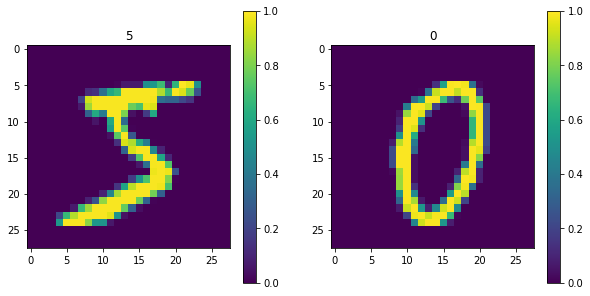

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.colorbar()
plt.title(y_train[0].item());
plt.subplot(1,2,2)
plt.imshow(x_train[1000])
plt.colorbar()
plt.title(y_train[1000].item());

# Tasks
* Train a classifier with fully-connected layers only.
* Train a classifier with convolutions only.
* Train a classifier with convolutions and fully-connected layers.
* Train a denoising network. Note, you have to create some noisy observations first ;)

# 1. Create model

In [6]:
class ConvOnly(nn.Module):
    def __init__(self):
        super(ConvOnly, self).__init__()
        self.conv0 = nn.Conv2d(1, 20, kernel_size=7, stride=3)
        self.conv1 = nn.Conv2d(20, 20, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(20, 10, kernel_size=2)
        
    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return F.log_softmax(x, dim = 1)

# 2. Test if model runs

In [7]:
model = ConvOnly()

In [8]:
x = x_train[:1]

In [9]:
model(x.unsqueeze(0)).shape

torch.Size([1, 10, 1, 1])

# 3. Choose loss-function and optimizer

In [10]:
loss_function = F.nll_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 4. Write train-loop

__Note:__ If you want to train on GPU just call `model.cuda()` to move the model to GPU. Don't forget to move the training data to GPU as well. You can call `x.cuda()` to move a tensor to GPU.

In [11]:
def train(model, x, y, loss_function, optimizer, num_epochs):
    # Make sure that the model is in train-mode
    model.train()
    
    min_loss = 99.99
    for e in tqdm(range(num_epochs)):
        running_loss = 0.0
        c = 0
        for i, (x_, y_) in tqdm(enumerate(zip(x, y)), leave=False):
            x_ = x_.unsqueeze(0)
            y_ = y_.unsqueeze(0)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_hat = model(x_)
            loss = loss_function(y_hat, y_)
            loss.backward()
            optimizer.step()
            
            if loss.item() < min_loss:
                min_loss = loss.item()
                torch.save(model.state_dict(), 'pytorch_mnist_smallest_train_loss.model')
            
            running_loss += loss.item() # .item() returns the scalar value of the tensor.
            c += 1
            if i % 10000 == 0:
                running_loss /= float(c)
                print('Train-Loss: {}'.format(np.round(running_loss, 3)))
                running_loss = 0.0
                c = 0

In [12]:
x_train.shape

torch.Size([60000, 28, 28])

In [13]:
torch.reshape(y_train, (y_train.shape[0], 1, 1)).shape

torch.Size([60000, 1, 1])

In [14]:
train(model, x_train.unsqueeze(1), torch.reshape(y_train, (y_train.shape[0], 1, 1)), 
      loss_function, optimizer, num_epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train-Loss: 2.35
Train-Loss: 1.283
Train-Loss: 1.015
Train-Loss: 0.966
Train-Loss: 0.93
Train-Loss: 0.908


0it [00:00, ?it/s]

Train-Loss: 0.939
Train-Loss: 0.847
Train-Loss: 0.822
Train-Loss: 0.764
Train-Loss: 0.608
Train-Loss: 0.602


0it [00:00, ?it/s]

Train-Loss: 0.171
Train-Loss: 0.569
Train-Loss: 0.552
Train-Loss: 0.555
Train-Loss: 0.56
Train-Loss: 0.562


0it [00:00, ?it/s]

Train-Loss: 0.173
Train-Loss: 0.543
Train-Loss: 0.527
Train-Loss: 0.535
Train-Loss: 0.54
Train-Loss: 0.544


0it [00:00, ?it/s]

Train-Loss: 0.15
Train-Loss: 0.529
Train-Loss: 0.512
Train-Loss: 0.523
Train-Loss: 0.527
Train-Loss: 0.532


# 5. Evaluate

In [15]:
# Use your own path ;)
mnist_test = torchvision.datasets.MNIST('/home/tibuch/Data/mnist', train=False, download=True,
                                         transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor()
                                         ]))

In [16]:
x_test = mnist_test.data.type(torch.float32)
x_test /= 255.
y_test = mnist_test.targets

In [17]:
model.load_state_dict(torch.load('pytorch_mnist_smallest_train_loss.model'))
model.eval()

ConvOnly(
  (conv0): Conv2d(1, 20, kernel_size=(7, 7), stride=(3, 3))
  (conv1): Conv2d(20, 20, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(20, 10, kernel_size=(2, 2), stride=(1, 1))
)

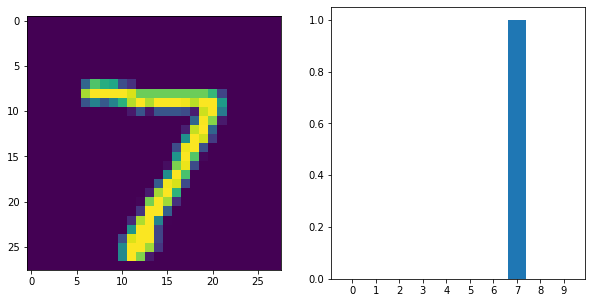

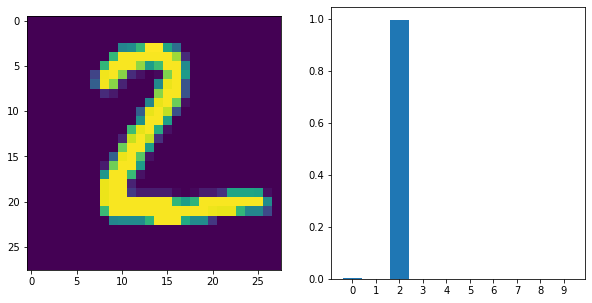

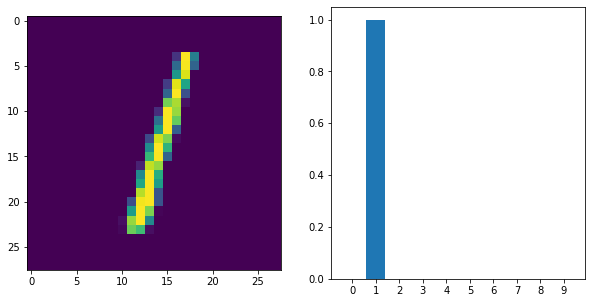

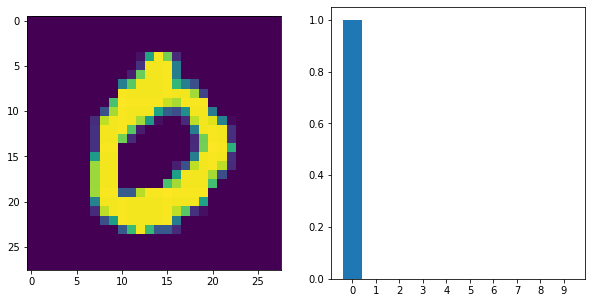

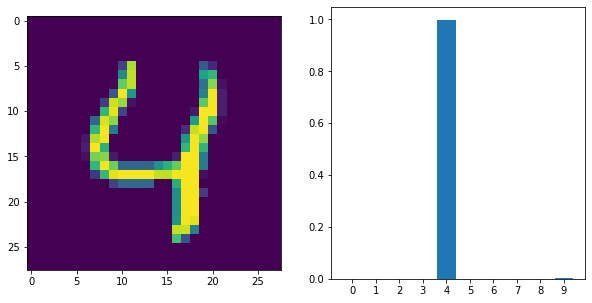

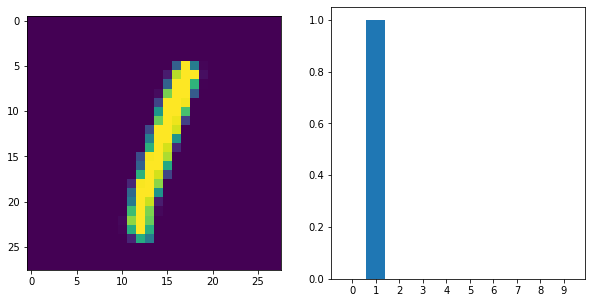

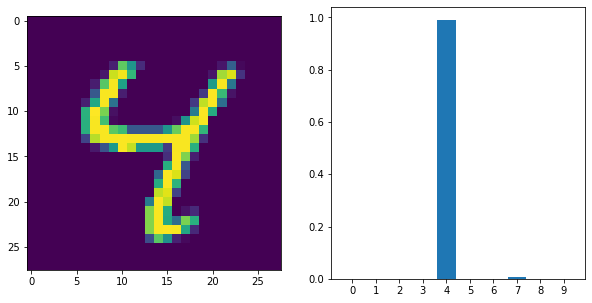

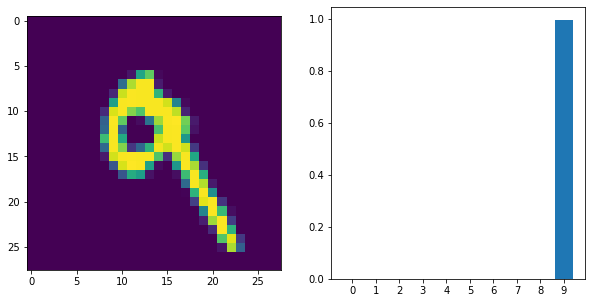

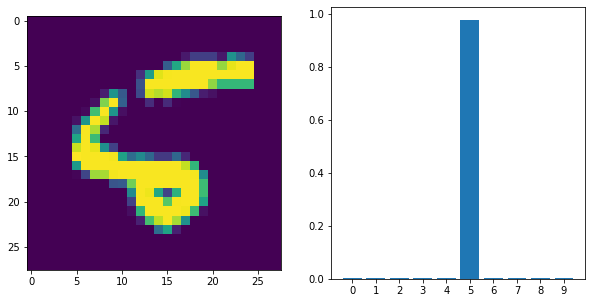

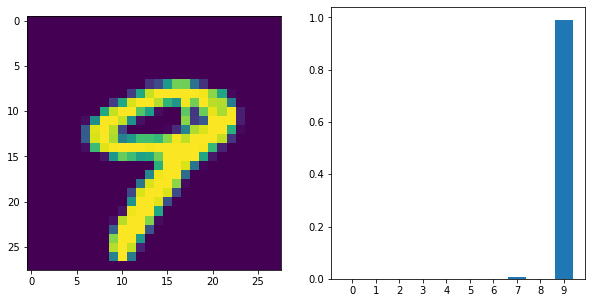

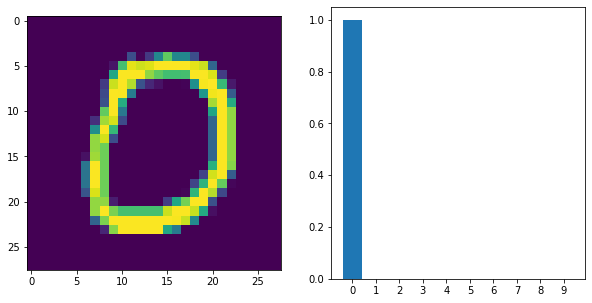

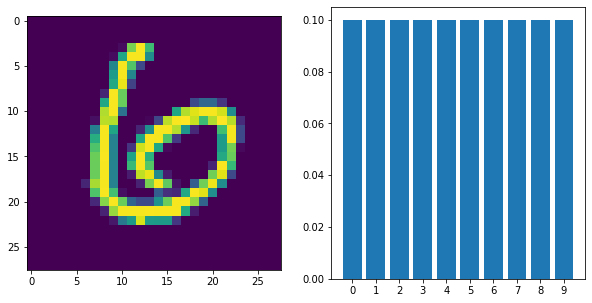

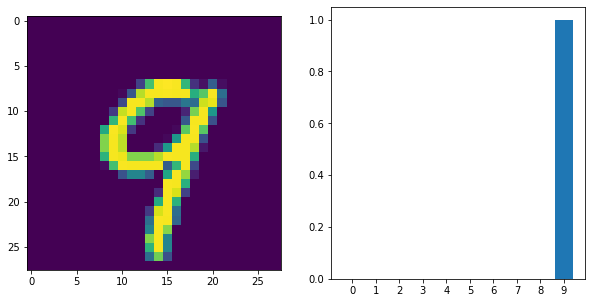

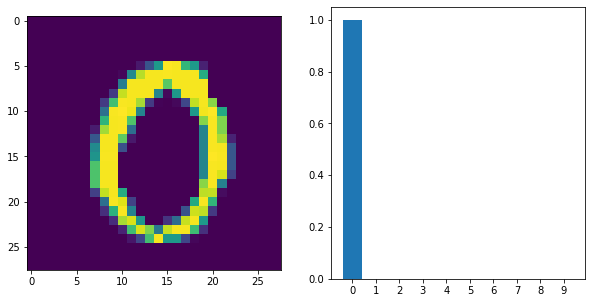

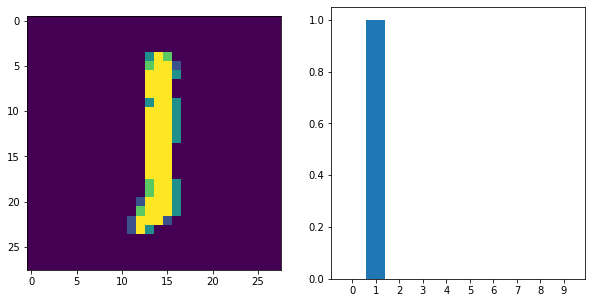

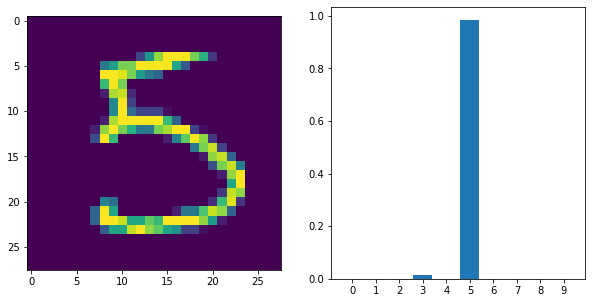

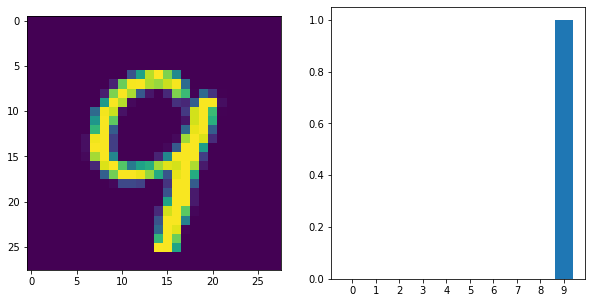

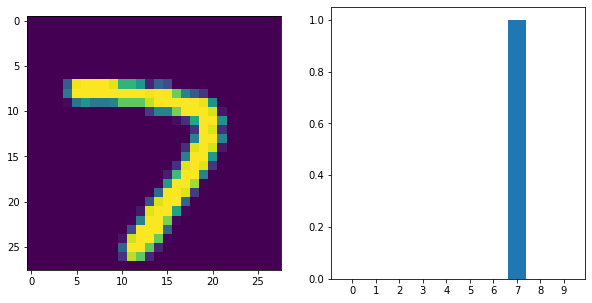

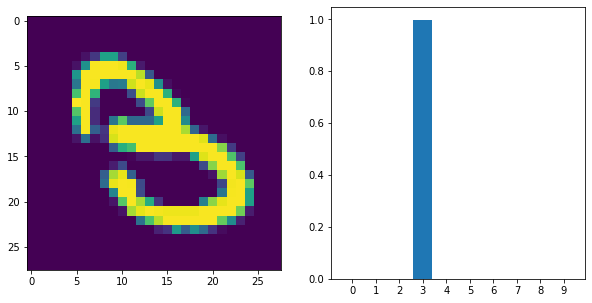

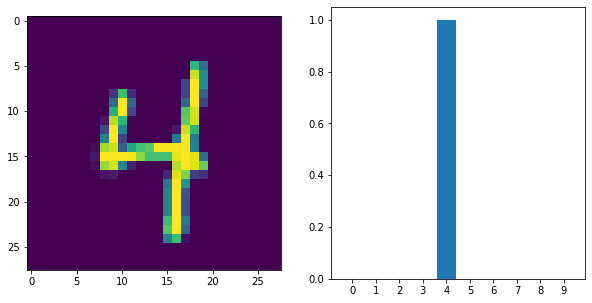

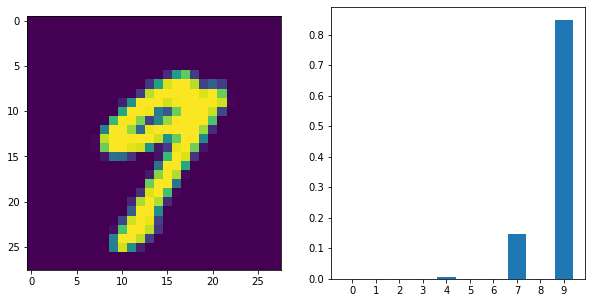

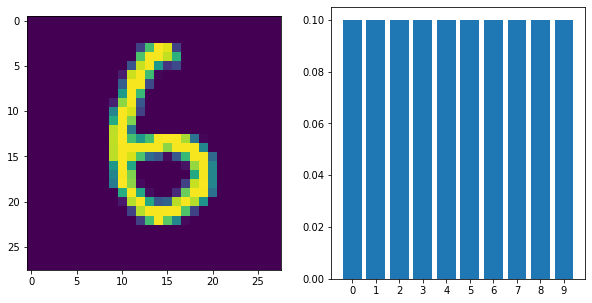

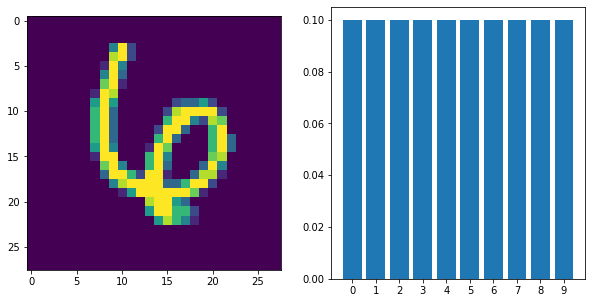

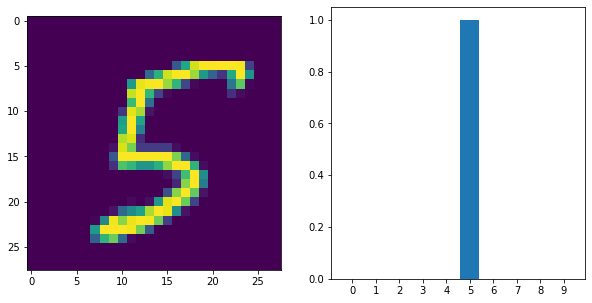

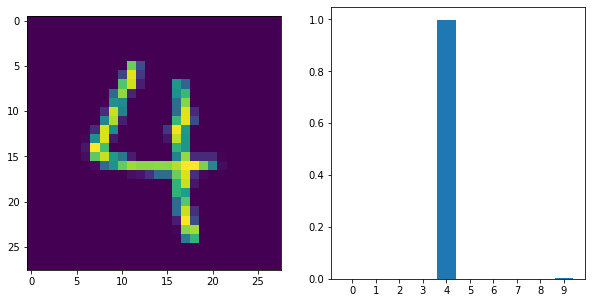

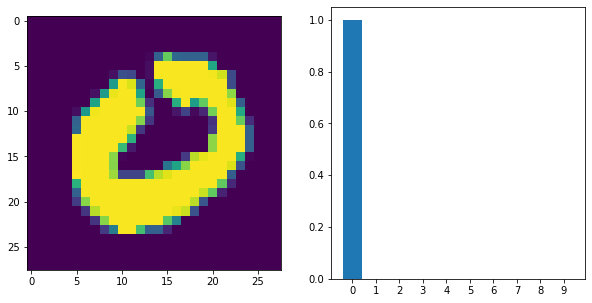

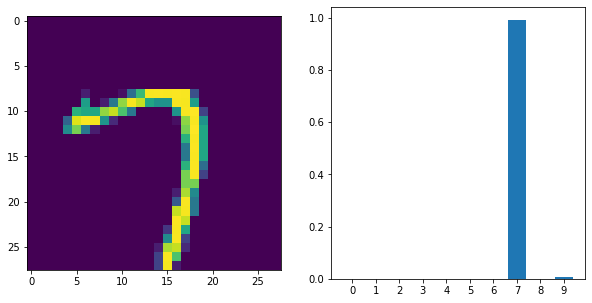

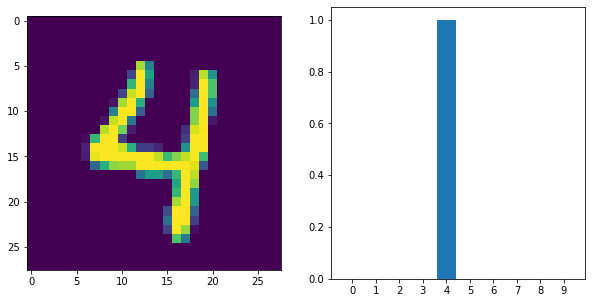

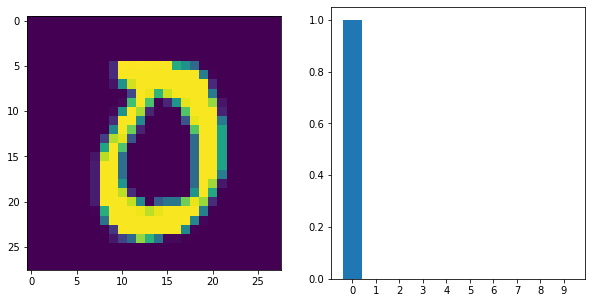

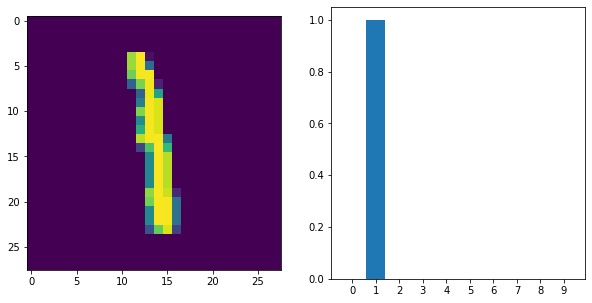

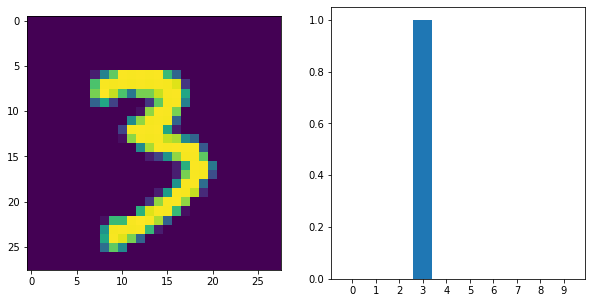

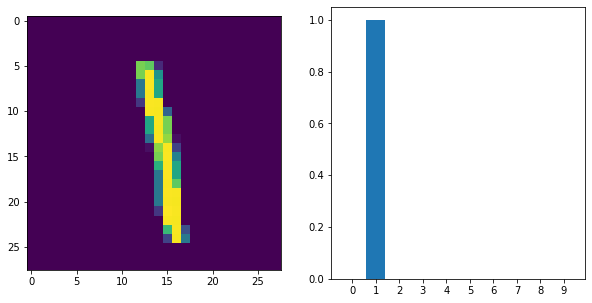

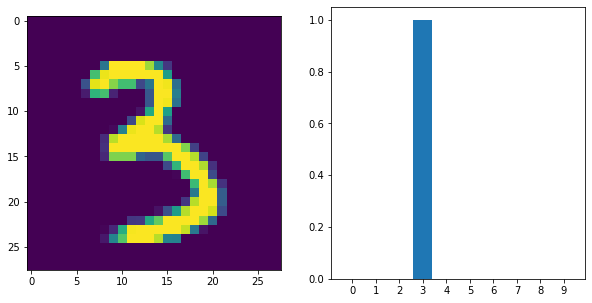

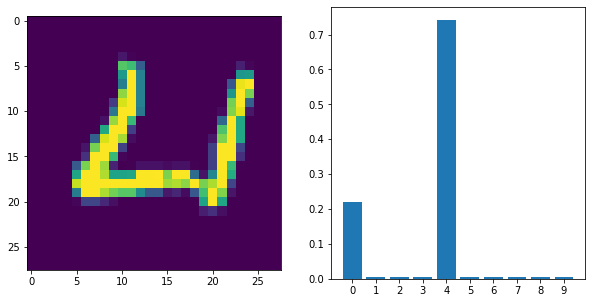

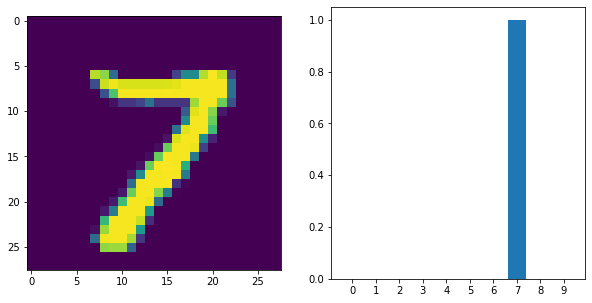

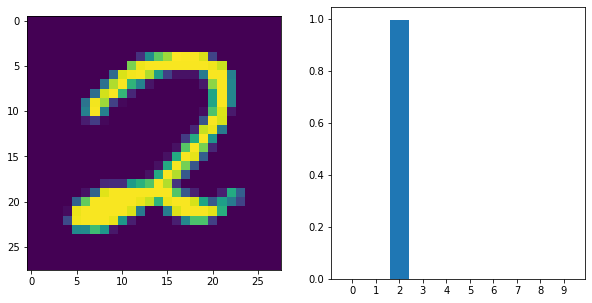

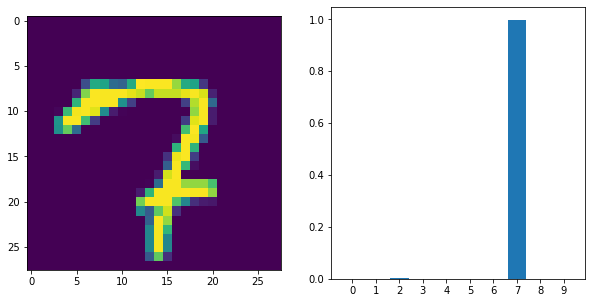

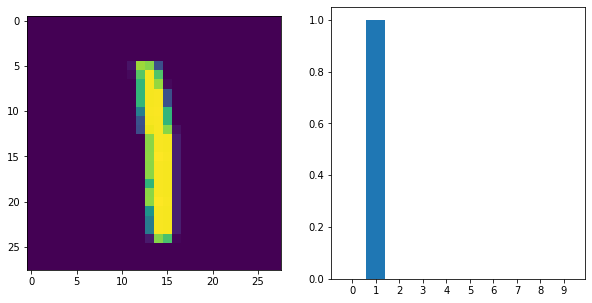

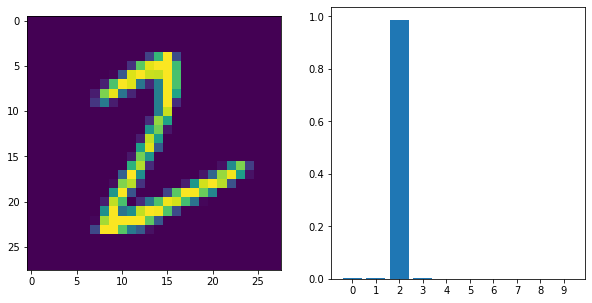

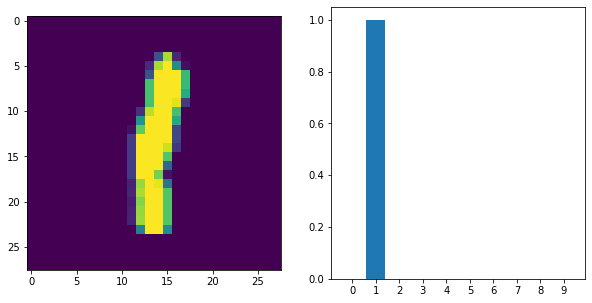

In [19]:
for i in range(40):
    test_img = x_test[i].unsqueeze(0).unsqueeze(1)
    test_target = y_test[i]

    pred = model(test_img)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(test_img[0, 0].detach())
    plt.subplot(1,2,2)
    plt.bar(np.arange(10), torch.exp(pred).detach().cpu().numpy()[0,:,0,0]);
    plt.xticks(np.arange(10));
    plt.show()